
##Predict Rating Scores with Text Reviews

Frist, we need an open dataset of free texts and rating scores, e.g., Women's E-Commerce Clothing Reviews on Kaggle (https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews). This dataset includes 23486 rows and 10 feature variables. Each row corresponds to a customer review, and includes the variables: 
- Clothing ID: Integer Categorical variable that refers to the specific piece being reviewed. 
- Age: Positive Integer variable of the reviewers age. 
- Title: String variable for the title of the review. 
- Review Text: String variable for the review body. 
- Rating: Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best. 
- Recommended IND: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended. 
- Positive Feedback Count: Positive Integer documenting the number of other customers who found this review positive.
- Division Name: Categorical name of the product high level division.
- Department Name: Categorical name of the product department name.
- Class Name: Categorical name of the product class name.

Please modify the codes from Lecture 12 and report the results of Mean Absolute Error and Root Mean Square Error on both Training dataset and Test dataset. Please note 
- You only use the Review text as the input to predict the Rating score.
- You split the dataset with the ratio 8-to-2 for the training set and the test set.
- You use the ‘glove.6B.50d.txt’ as the word embedding tool.
- You only use the first 100 words of each review as the input of the model.
- You add 100 LSTM nodes in the layer.

You optimize the model for 20 epochs. You may add more layers in your LSTM model to achieve better results after reporting the required tasks.

## Setting

In [ ]:
# Check Your GPU device
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
import keras
# Connect to your google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read a file in the Notebook folder
import os 
os.chdir('/content/drive/My Drive/Colab Notebooks')
!ls

# Data Preperation

Importing Required libraries 


Reading the data file **“Womens-Clothing-E-Commerce-Reviews.csv”** in pandas.

The documentation states that the dataset consists of 23,486 rows and 11 features. The features include:

*   **Clothing ID:** Integer Categorical variable that refers to the specificpiece being reviewed.
*   **Age**: Positive Integer variable of the reviewers age.
*   **Title**: String variable for the title of the review.
*   **Review Text**: String variable for the review body.
*   **Rating**: Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.
*   **Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.
*  **Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.
*   **Division Name:** Categorical name of the product high level division.
*   **Department Name:** Categorical name of the product department name.
*   **Class Name:** Categorical name of the product class name.













In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import seaborn as sns

data = pd.read_csv('Womens-Clothing-E-Commerce-Reviews.csv')
data.head(5)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


# Data Exploration

In [ ]:
print('Number of Rows and Columns in dataset is= {}'.format(data.shape))


Number of Rows and Columns in dataset is= (23486, 11)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [ ]:
data.describe()

,Unnamed: 0,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,11742.500000,918.118709,43.198544,4.196032,0.822362,2.535936
std,6779.968547,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000
25%,5871.250000,861.000000,34.000000,4.000000,1.000000,0.000000
50%,11742.500000,936.000000,41.000000,5.000000,1.000000,1.000000
75%,17613.750000,1078.000000,52.000000,5.000000,1.000000,3.000000
max,23485.000000,1205.000000,99.000000,5.000000,1.000000,122.000000


In [ ]:
data.corr()

,Unnamed: 0,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
Unnamed: 0,1.000000,-0.006072,-0.007749,-0.002568,-0.003887,-0.002907
Clothing ID,-0.006072,1.000000,0.017972,-0.018879,-0.016206,0.046356
Age,-0.007749,0.017972,1.000000,0.026831,0.030622,0.043079
Rating,-0.002568,-0.018879,0.026831,1.000000,0.792336,-0.064961
Recommended IND,-0.003887,-0.016206,0.030622,0.792336,1.000000,-0.069045
Positive Feedback Count,-0.002907,0.046356,0.043079,-0.064961,-0.069045,1.000000


Number of unique values in each features:

In [ ]:
print(f'Number of unique values =\n{data.nunique()}(training)')

Number of unique values =
Unnamed: 0                 23486
Clothing ID                 1206
Age                           77
Title                      13993
Review Text                22634
Rating                         5
Recommended IND                2
Positive Feedback Count       82
Division Name                  3
Department Name                6
Class Name                    20
dtype: int64(training)


**Title** and **Review Text** both had missing values. For Title the missing values amounted to approximately 17% in total of the records which is titel is 15% and Review Text is about 3%.

In [ ]:
print('Number of missing data are \n{}'.format(data.isnull().sum()))

Number of missing data are 
Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text major ticklabel objects>)

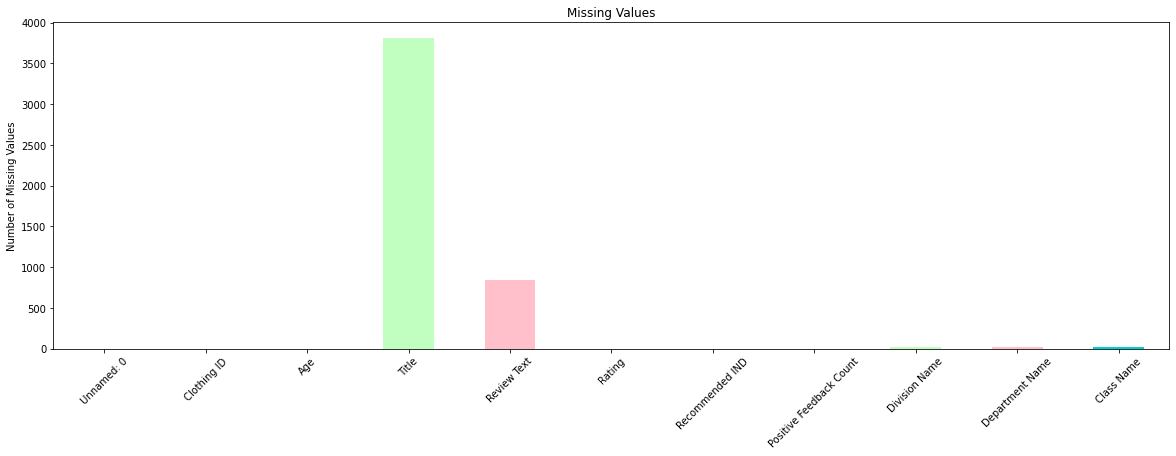

In [ ]:
data.isnull().sum().plot(kind='bar',figsize=(20, 6), rot=0,color=['#00CED1','#5bc0de','#CAFF70', '#C1FFC1', '#FFC0CB'])
plt.ylabel("Number of Missing Values")
plt.title("Missing Values")
plt.xticks(rotation=45)


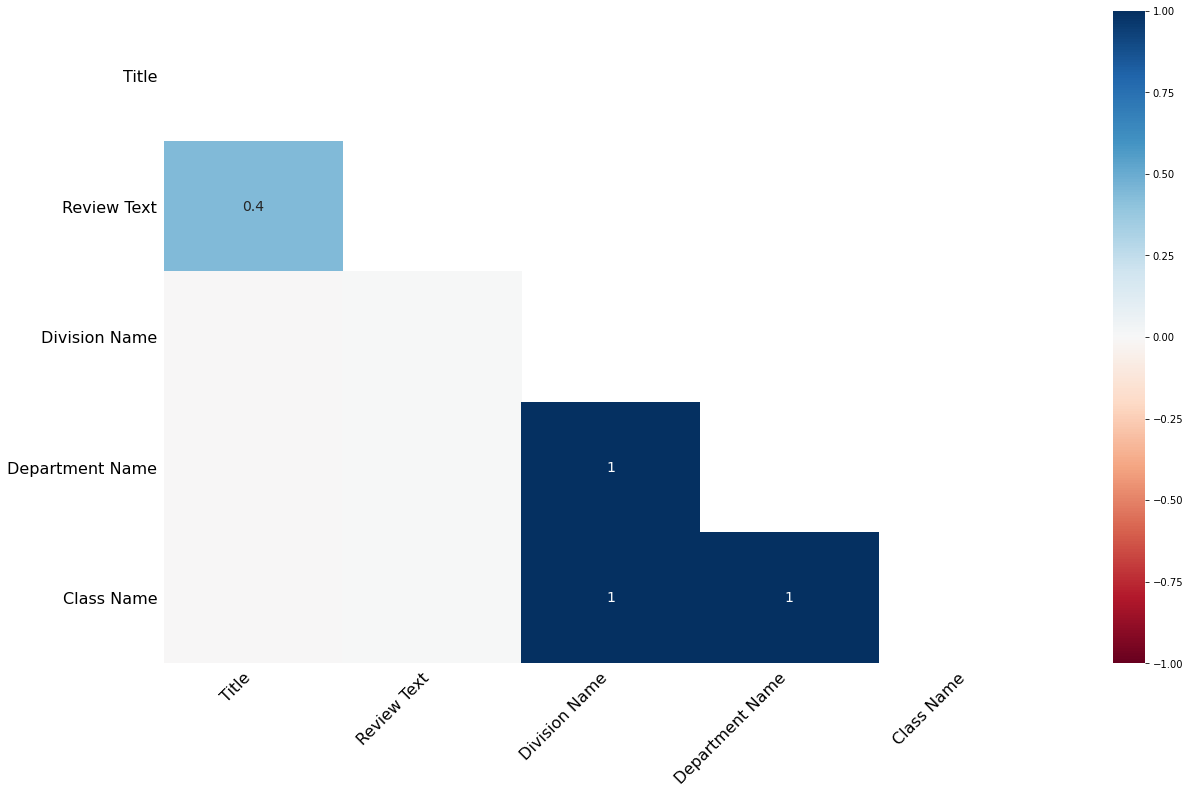

In [ ]:
import pandas as pd
import missingno as msno


msno.heatmap(df)

We're excluding these columns because they're unimportant to the review's sentiment study.

In [ ]:
data.drop(['Clothing ID', 'Title', 'Unnamed: 0'], axis = 1, inplace = True)

Null records in **Review Text** column

In [ ]:
data[data['Review Text'].isnull()]

,Age,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
92,23,NaN,5,1,0,General Petite,Tops,Knits
93,31,NaN,5,1,0,General,Dresses,Dresses
98,50,NaN,5,1,0,General,Jackets,Outerwear
135,35,NaN,4,1,0,General Petite,Tops,Knits
142,35,NaN,5,1,0,General,Jackets,Outerwear
...,...,...,...,...,...,...,...,...
23258,35,NaN,4,1,0,General,Tops,Knits
23301,52,NaN,5,1,0,General,Tops,Knits
23303,46,NaN,5,1,0,General,Tops,Blouses
23470,39,NaN,5,1,0,General Petite,Dresses,Dresses


Only 3.5% of the records were missing were from **Review Text** so the rows missing a value in this column were also be dropped. So the data without missing value in **Review Text** is saved as name: **dataset** 

In [ ]:
#taking out the rows with null values
dataset = data.dropna(subset=['Review Text'])
dataset = dataset.reset_index(drop=True)
dataset.isnull().sum()


Age                         0
Review Text                 0
Rating                      0
Recommended IND             0
Positive Feedback Count     0
Division Name              13
Department Name            13
Class Name                 13
dtype: int64

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22641 entries, 0 to 22640
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      22641 non-null  int64 
 1   Review Text              22641 non-null  object
 2   Rating                   22641 non-null  int64 
 3   Recommended IND          22641 non-null  int64 
 4   Positive Feedback Count  22641 non-null  int64 
 5   Division Name            22628 non-null  object
 6   Department Name          22628 non-null  object
 7   Class Name               22628 non-null  object
dtypes: int64(4), object(4)
memory usage: 1.4+ MB


Dataset does not have the **'Unname', 'Clothing ID', 'Title' columns,**  and the null values in 'Review Text" column

In [ ]:
dataset.columns

Index(['Age', 'Review Text', 'Rating', 'Recommended IND',
       'Positive Feedback Count', 'Division Name', 'Department Name',
       'Class Name'],
      dtype='object')

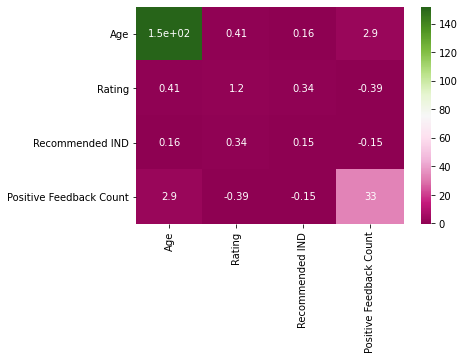

In [ ]:
df= dataset.cov()
sns.heatmap(df,annot=True,cmap="PiYG")

A count of **unique categories** in each feature was taken by using pysql

In [ ]:
#Find out how many categories are in each categorical feature
#sql package for data wrangling
!pip install -U pandasql
from pandasql import sqldf
#going to use python sqldf package for some of this querying so lets just assign the function
pysqldf = lambda q: sqldf(q,globals())

div = pysqldf("""select 'Division Name' as Feature, count(distinct([Division Name])) as num_distinct from dataset""")
dep = pysqldf("""select 'Department Name' as Feature, count(distinct([Department Name])) as num_distinct from dataset""")
clas = pysqldf("""select 'Class Name' as Feature, count(distinct([Class Name])) as num_distinct from dataset""")


cats = pd.concat([div, dep, clas])
cats

Requirement already up-to-date: pandasql in /usr/local/lib/python3.7/dist-packages (0.7.3)


,Feature,num_distinct
0,Division Name,3
0,Department Name,6
0,Class Name,20


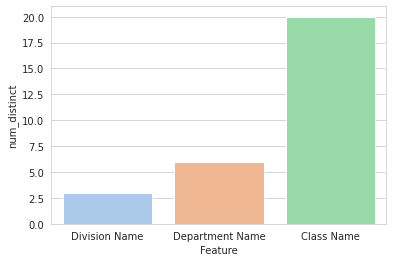

In [ ]:
sns.set_style('whitegrid')
sns.barplot(x='Feature', y='num_distinct',data=cats,palette='pastel')

A count of unique categories in  **"Division Name"**

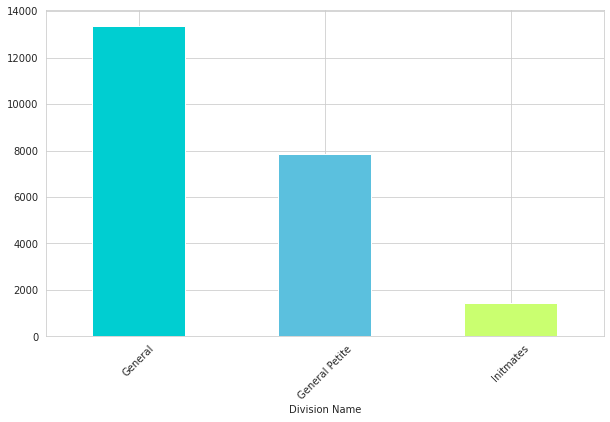

In [ ]:
Division_Name= dataset.groupby('Division Name')['Division Name'].size().plot(kind='bar', color=['#00CED1','#5bc0de','#CAFF70', '#C1FFC1', '#FFC0CB'],figsize = (10,6))
plt.xticks(rotation=45)
plt.show()

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

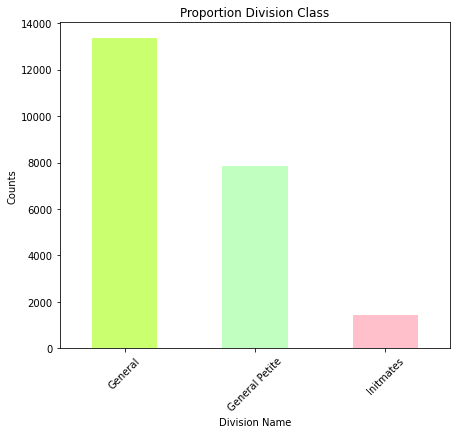

In [ ]:
dataset['Division Name'].value_counts().plot(kind='bar',figsize=(7, 6), rot=0,color=['#CAFF70', '#C1FFC1', '#FFC0CB'])
plt.xlabel('Division Name')
plt.ylabel("Counts")
plt.title("Proportion Division Class")
plt.xticks(rotation=45)

A count of unique categories in  **"Department Name"**

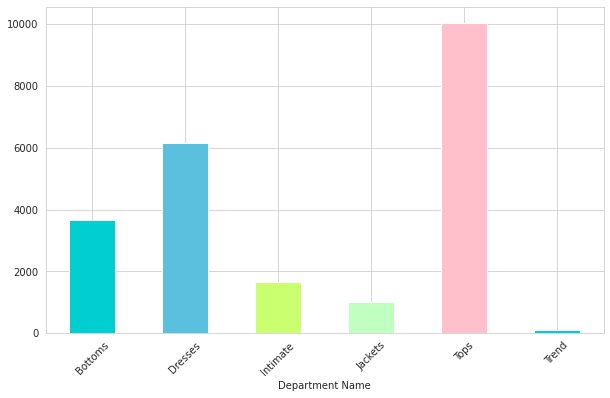

In [ ]:
Department_Name= dataset.groupby('Department Name')['Department Name'].size().plot(kind='bar', color=['#00CED1','#5bc0de','#CAFF70', '#C1FFC1', '#FFC0CB'],figsize = (10,6))
plt.xticks(rotation=45)
plt.show()


A count of unique categories in  **"Class Name"**

**Dresses**, **Knits** and **Blouses**  are bought the most by women by 6000 ,4500 and 3000 respectively. **Casual Bottoms** and **Chemises** are the least favorite. 

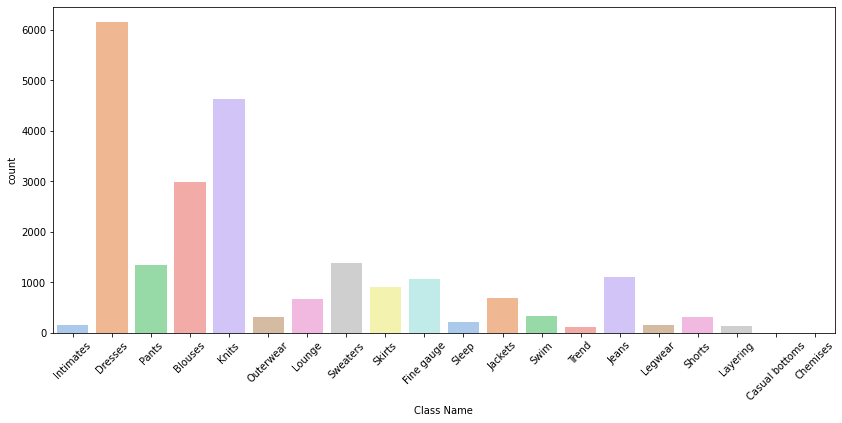

In [ ]:
plt.figure(figsize = (14,6))
sns.countplot(x = 'Class Name', data = dataset, palette = 'pastel')
plt.xticks(rotation = 45)
plt.show()

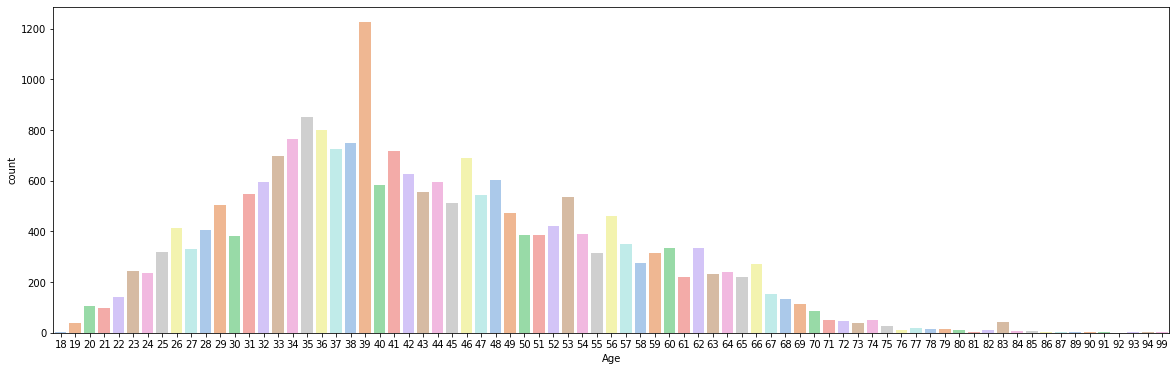

In [ ]:
plt.figure(figsize = (20,6))
sns.countplot(x = 'Age', data = dataset, palette = 'pastel')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


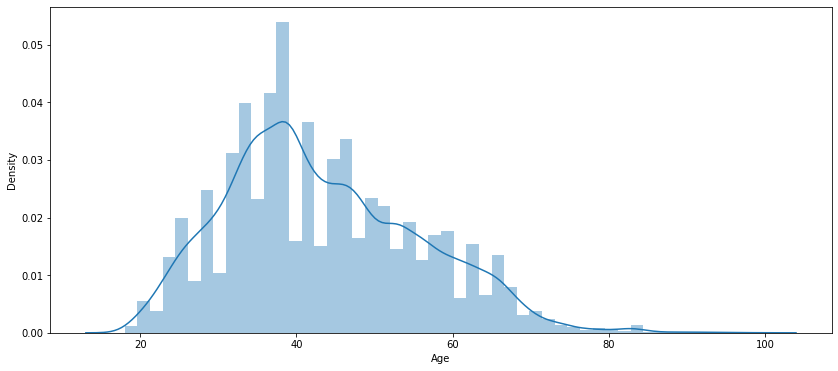

In [ ]:
f, axes = plt.subplots(figsize=(14,6))
sns.distplot(dataset['Age'])


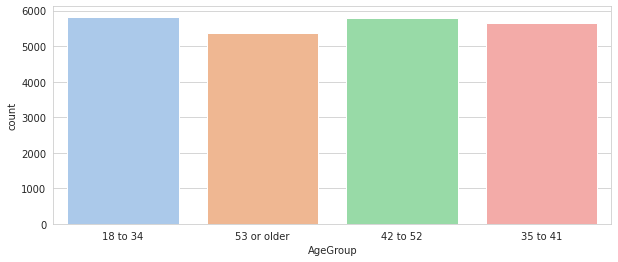

In [ ]:
# createing a new categorial variable called Age group based on the quartiles
age_grouping = pysqldf("""select *,
(case when [Age] between 18 and 34 then '18 to 34'
    when [Age] between 35 and 41 then '35 to 41'
    when [Age] between 42 and 52 then '42 to 52'
    else '53 or older' end) as AgeGroup
    from dataset""")

agegrouping = pd.DataFrame(age_grouping)
plt.figure(figsize = (10,4))
sns.countplot(x='AgeGroup',data=agegrouping,palette='pastel')
plt.show()


There's no significant association between Age and Positive Feedback, excluding some outliers

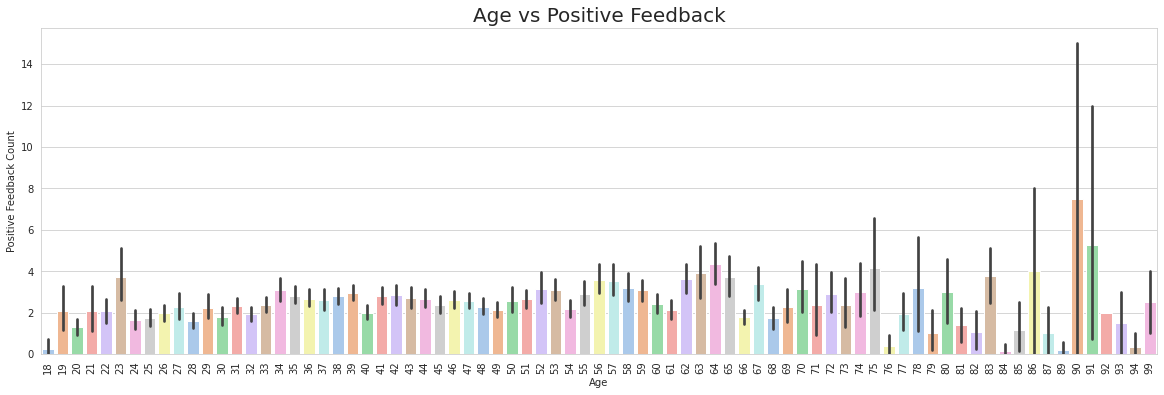

In [ ]:
plt.figure(figsize = (20,6))
sns.barplot(x ='Age',y= 'Positive Feedback Count',data = dataset,  palette = 'pastel')
plt.title('Age vs Positive Feedback', fontsize = 20)
plt.xticks(rotation = 90)
plt.show()

There's no significant association between Age and Rating, excluding some outliers.

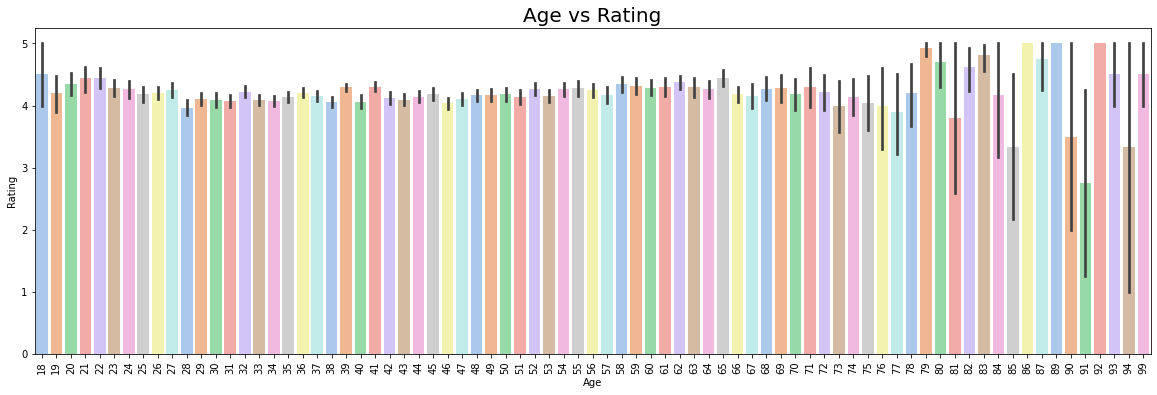

In [ ]:
plt.figure(figsize = (20,6))

sns.barplot(x ='Age',y= 'Rating',data = dataset, palette = 'pastel')
plt.title('Age vs Rating', fontsize = 20)
plt.xticks(rotation = 90)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


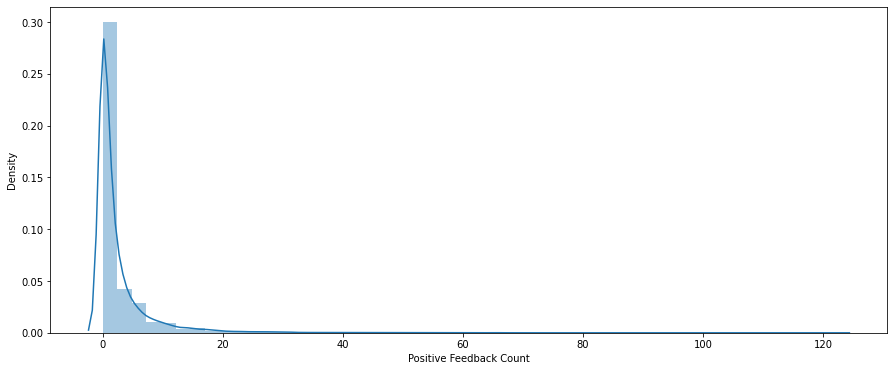

In [ ]:
plt.figure(figsize = (15,6))
sns.distplot(dataset['Positive Feedback Count'])
plt.show()

Text(0.5, 1.0, 'Proportion Rating Class')

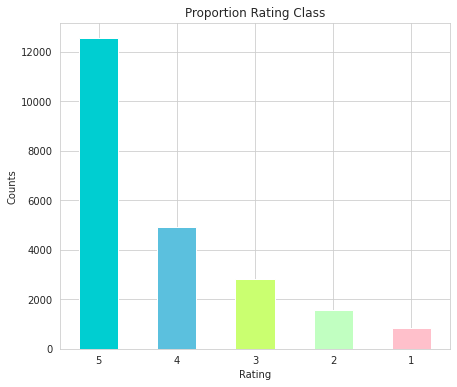

In [ ]:
dataset["Rating"].value_counts().plot(kind='bar',figsize=(7, 6), rot=0,color=['#00CED1','#5bc0de','#CAFF70', '#C1FFC1', '#FFC0CB'])
plt.xlabel("Rating")
plt.ylabel("Counts")
plt.title("Proportion Rating Class")

Rating 5 is the highest portion and least is 1. 

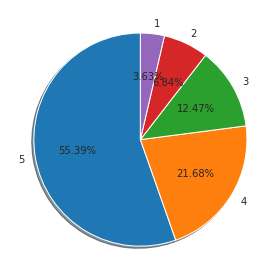

In [ ]:
# Pie chart
ax =dataset.Rating.value_counts() 
labels=dataset['Rating'].value_counts().index
fig1, ax1 = plt.subplots()
ax1.pie(ax,labels=labels, autopct='%1.2f%%',shadow=True, startangle=90) 
plt.tight_layout()
plt.show()

The  **'Recommended IND'**  feature has two categories of zero and 1. Feature 1 means recommended and 0 means not recommended. The dataset has 18540 rows of recommneded ID of 1 and 4101 of not recommended ID of 0. 

In [ ]:
dataset[['Review Text', 'Recommended IND']]

,Review Text,Recommended IND
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1
...,...,...
22636,I was very happy to snag this dress at such a ...,1
22637,"It reminds me of maternity clothes. soft, stre...",1
22638,"This fit well, but the top was very see throug...",0
22639,I bought this dress for a wedding i have this ...,1


In [ ]:
dataset['Recommended IND'].value_counts()

1    18540
0     4101
Name: Recommended IND, dtype: int64

The bar chart below illustrates about 81% of the Recommended ID is 1. 

Text(0, 0.5, 'Counts')

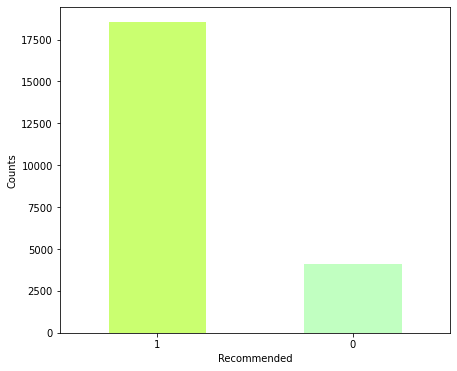

In [ ]:
dataset["Recommended IND"].value_counts().plot(kind='bar',figsize=(7, 6), rot=0,color=['#CAFF70', '#C1FFC1'])
plt.xlabel("Recommended")
plt.ylabel("Counts")


In [ ]:
dataset[dataset['Recommended IND']== 1][['Review Text','Recommended IND']][20:30]

,Review Text,Recommended IND
24,"I love this shirt because when i first saw it,...",1
27,The colors weren't what i expected either. the...,1
28,I have several of goodhyouman shirts and i get...,1
29,This sweater is so comfy and classic - it bala...,1
30,Beautifully made pants and on trend with the f...,1
31,I never would have given these pants a second ...,1
32,These pants are even better in person. the onl...,1
34,This is such a neat dress. the color is great ...,1
35,Wouldn't have given them a second look but tri...,1
36,This is a comfortable skirt that can span seas...,1


In [ ]:
dataset[dataset['Recommended IND']== 0][['Review Text','Recommended IND']][20:30]

,Review Text,Recommended IND
101,"Runs big and looked unflattering. i am petite,...",0
107,This is so thin and poor quality. especially f...,0
111,The design/shape of the dress are quite flatte...,0
115,"First, the fabric is beautiful and lovely for ...",0
121,I was so excited to try out this top since it ...,0
139,My firned tried this on and her first comment ...,0
147,Not keeping this one. the fabric is a bit tack...,0
152,So disappointed that no where in the limiting...,0
156,The title says it all....this fabric of this t...,0
171,The colors are vivid and perfectly autumnal bu...,0


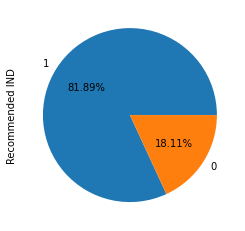

In [ ]:
dataset['Recommended IND'].value_counts().plot.pie(autopct='%1.2f%%')


The graph below illustrates that recommended products have the rates above the 3.

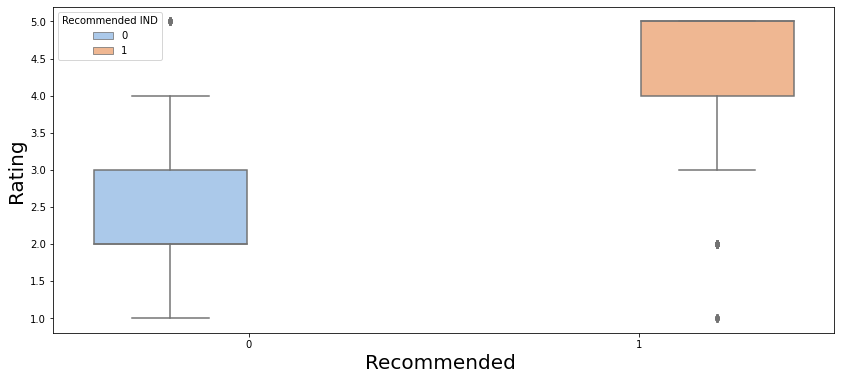

In [ ]:
plt.figure(figsize = (14,6 ))
sns.boxplot(x="Recommended IND", y="Rating", hue = "Recommended IND", data = dataset, palette = 'pastel')
plt.xlabel("Recommended ", fontsize = 20)
plt.ylabel("Rating", fontsize = 20)

plt.show()

In [ ]:
import nltk
import re
import string
from wordcloud import WordCloud
from nltk.corpus import stopwords
from keras.preprocessing import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#Clean the text
# Remove all the noises
def preProcess_text(words):
    
    words = re.sub("[^a-zA-Z]"," ", words)
    text = words.lower().split()                   
    return " ".join(text)

In [ ]:
# Apply the clean_text function to test and training datasets 
dataset1=dataset.copy()
dataset1['Review_clear'] = dataset1['Review Text'].apply(lambda x: preProcess_text(x))

In [ ]:
#Cleaned text data
def text_clean(before_clean,after_clean):
    
    print('-'*60)
    print('Text before clean up')
    print('-'*60)
    print(before_clean.head(7))
    print('-'*60)
    print('Text after clean up')
    print('-'*60)
    print(after_clean.head(7))

In [ ]:
text_clean(dataset['Review Text'],dataset1['Review_clear'])

------------------------------------------------------------
Text before clean up
------------------------------------------------------------
0    Absolutely wonderful - silky and sexy and comf...
1    Love this dress!  it's sooo pretty.  i happene...
2    I had such high hopes for this dress and reall...
3    I love, love, love this jumpsuit. it's fun, fl...
4    This shirt is very flattering to all due to th...
5    I love tracy reese dresses, but this one is no...
6    I aded this in my basket at hte last mintue to...
Name: Review Text, dtype: object
------------------------------------------------------------
Text after clean up
------------------------------------------------------------
0    absolutely wonderful silky and sexy and comfor...
1    love this dress it s sooo pretty i happened to...
2    i had such high hopes for this dress and reall...
3    i love love love this jumpsuit it s fun flirty...
4    this shirt is very flattering to all due to th...
5    i love tracy rees

In [ ]:
!pip install TextBlob
from textblob import *

dataset1['polarity'] = dataset1['Review_clear'].map(lambda text: TextBlob(text).sentiment.polarity)
dataset1['polarity']

0        0.633333
1        0.318750
2        0.073131
3        0.500000
4        0.393750
           ...   
22636    0.512667
22637    0.091667
22638    0.414286
22639    0.316667
22640    0.364444
Name: polarity, Length: 22641, dtype: float64

In [ ]:
import plotly.express as px
px.histogram(dataset1, x = 'polarity',color="Rating", opacity = 0.5)

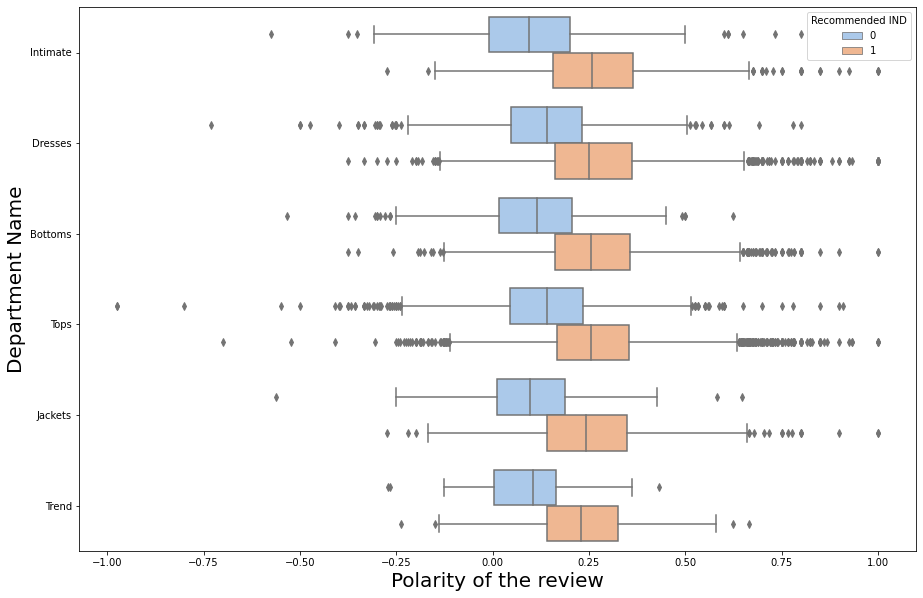

In [ ]:
plt.figure(figsize = (15,10))
sns.boxplot(x="polarity", y="Department Name", hue = "Recommended IND", data = dataset1, palette = 'pastel')
plt.xlabel("Polarity of the review", fontsize = 20)
plt.ylabel("Department Name", fontsize = 20)

plt.show()

In [ ]:
# Reviews with positive polarity
Positive = dataset1.loc[dataset1.polarity == 1,['Review_clear']].sample(3).values
for i in Positive:
    print(i[0])

if there ever was the perfect feminine dress this would be it
fits perfect
i ordered the orange color too these are perfect for throwing on over workout clothes and then running errands


In [ ]:
# Reviews with neutral polarity
Neutral = dataset1.loc[dataset1.polarity == 0.5,['Review_clear']].sample(3).values
for i in Neutral:
    print(i[0])

the jeans are soft and comfortable they are the perfect staple in my closet more colors please
i wore this dress to a party once and haven t been able to find an outfit that can top it
nice print and comfortable shirt


In [ ]:
# Reviews with negative polarity
Negative = dataset1.loc[dataset1.polarity < 0,['Review_clear']].sample(3).values
for i in Negative:
    print(i[0])

really disappointing quality these jeans are of a very poor quality material and developed holes in the inseams after only a month i love pilcros and am totally shocked at the poor quality retailer i hope this is just a fluke not worth the money
agree with other reviewers this runs narrow in the skirt the top is also quite low cut and it s already lined so i can t see wearing a cami or slip i like the black and white print and the shape and might have tried a size larger in the store finally it s an awkward unflattering length i m and it hit below my knee
i agree with the other reviewer the concept of this is fantastic but sadly did not work for me first of all it runs so small i normally wear a and ordered a and i still had a hard time closing over my ddd chest but i am abnormal anyways the peplum i wish was a little more subdued like in the photo maybe its because im so curvy but it just didn t work for me sadly its going back


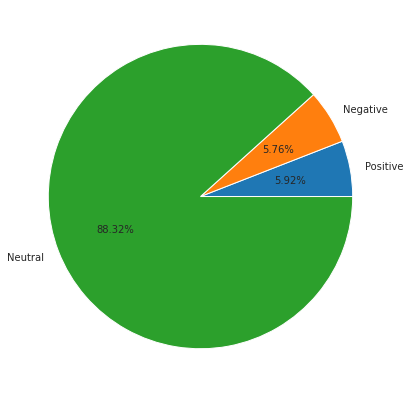

In [ ]:
negative = (len(dataset1.loc[dataset1.polarity < 0, ['Review_clear']].values)/len(dataset1))*100
positive = (len(dataset1.loc[dataset1.polarity > 0.5, ['Review_clear']].values)/len(dataset1))*100
neutral = len(dataset1.loc[dataset1.polarity >0 ,['Review_clear']].values) - len(dataset1.loc[dataset1.polarity >0.5 ,['Review Text']].values)
neutral = neutral/len(dataset1)*100
plt.figure(figsize =(10, 7)) 
plt.pie([positive,negative,neutral], labels = ['Positive','Negative','Neutral'],autopct='%1.2f%%') 
plt.show()

In [ ]:
dataset1['Review_clear'] = dataset1['Review_clear'].astype(str)

In [ ]:
! pip install nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

#clothing stopwords
clothes =['dress','color','wear','top','sweater','material','shirt','jeans','pant',
          'skirt','order','white','black','fabric','blouse','sleeve','even', 'jacket']

# Show some stop words
stop_words = stopwords.words('english')
print(stop_words[::10])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', "you've", 'himself', 'they', 'that', 'been', 'a', 'while', 'through', 'in', 'here', 'few', 'own', 'just', 're', 'doesn', 'ma', "shouldn't"]


In [ ]:
def stopwords(dataset1):
    text = [word.lower() for word in dataset1.split() if word.lower() not in stop_words and word.lower() not in clothes]
    return " ".join(text)


In [ ]:
dataset1['Review_clear'] = dataset1['Review_clear'].apply(stopwords)

In [ ]:
#Cleaned text data
def text_nostop(before_stop,after_nostop):
    
    print('-'*60)
    print('Text before stop')
    print('-'*60)
    print(before_stop.head(7))
    print('-'*60)
    print('Text after no stop')
    print('-'*60)
    print(after_nostop.head(7))

In [ ]:
text_nostop(dataset['Review Text'],dataset1['Review_clear'])

------------------------------------------------------------
Text before stop
------------------------------------------------------------
0    Absolutely wonderful - silky and sexy and comf...
1    Love this dress!  it's sooo pretty.  i happene...
2    I had such high hopes for this dress and reall...
3    I love, love, love this jumpsuit. it's fun, fl...
4    This shirt is very flattering to all due to th...
5    I love tracy reese dresses, but this one is no...
6    I aded this in my basket at hte last mintue to...
Name: Review Text, dtype: object
------------------------------------------------------------
Text after no stop
------------------------------------------------------------
0          absolutely wonderful silky sexy comfortable
1    love sooo pretty happened find store glad bc n...
2    high hopes really wanted work initially ordere...
3    love love love jumpsuit fun flirty fabulous ev...
4    flattering due adjustable front tie perfect le...
5    love tracy reese dress

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

lem = WordNetLemmatizer()

def lemma(text):
    lem_text = [lem.lemmatize(word) for word in text.split()]
    return " ".join(lem_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
dataset1['Review_clear'] = dataset1['Review_clear'].apply(lemma)

In [ ]:
#Cleaned text data
def text_lemma(before_lemma,after_lemma):
    
    print('-'*60)
    print('Text before lemma')
    print('-'*60)
    print(before_stop.head(7))
    print('-'*60)
    print('Text after lemma')
    print('-'*60)
    print(after_nostop.head(7))

In [ ]:
text_nostop(dataset['Review Text'],dataset1['Review_clear'])

------------------------------------------------------------
Text before stop
------------------------------------------------------------
0    Absolutely wonderful - silky and sexy and comf...
1    Love this dress!  it's sooo pretty.  i happene...
2    I had such high hopes for this dress and reall...
3    I love, love, love this jumpsuit. it's fun, fl...
4    This shirt is very flattering to all due to th...
5    I love tracy reese dresses, but this one is no...
6    I aded this in my basket at hte last mintue to...
Name: Review Text, dtype: object
------------------------------------------------------------
Text after no stop
------------------------------------------------------------
0          absolutely wonderful silky sexy comfortable
1    love sooo pretty happened find store glad bc n...
2    high hope really wanted work initially ordered...
3    love love love jumpsuit fun flirty fabulous ev...
4    flattering due adjustable front tie perfect le...
5    love tracy reese dress

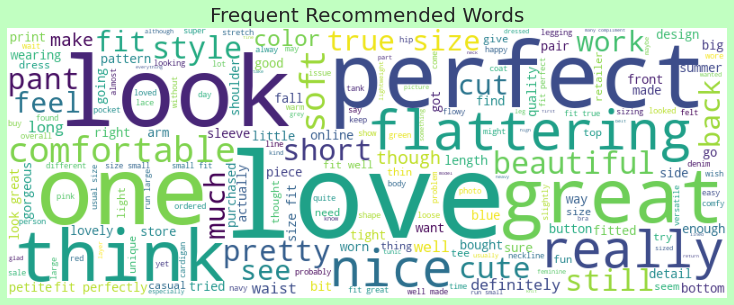

In [ ]:
Frequent_Recommended_words = ''.join(list(dataset1[dataset1['Recommended IND']==1]['Review_clear']))
Recommended_words = WordCloud(width = 800,height = 300, background_color='white').generate(Frequent_Recommended_words )
plt.figure(figsize = (10, 5), facecolor='#C1FFC1')
plt.imshow(Recommended_words)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.title('Frequent Recommended Words',fontsize=20)
plt.show()

# Predict Rating Scores with Text Reviews with Long Term Short Memory (LSTM) model.


To develop the model, we'll need input and predictions, which we'll get from the dataset's features and labels.Below the Reviews Text and Ratings Columns have been taken out for building the model. 

In [ ]:
#Taking out the Reviews and Ratings Columns
dataset2 = dataset.iloc[:,[1,2]]
dataset2.head(5)

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,4
1,Love this dress! it's sooo pretty. i happene...,5
2,I had such high hopes for this dress and reall...,3
3,"I love, love, love this jumpsuit. it's fun, fl...",5
4,This shirt is very flattering to all due to th...,5


In [ ]:
# Building the model
# Seperating label and features
X = dataset2.iloc[:,0]    
Y = dataset2.iloc[:,1]  
X

0        Absolutely wonderful - silky and sexy and comf...
1        Love this dress!  it's sooo pretty.  i happene...
2        I had such high hopes for this dress and reall...
3        I love, love, love this jumpsuit. it's fun, fl...
4        This shirt is very flattering to all due to th...
                               ...                        
22636    I was very happy to snag this dress at such a ...
22637    It reminds me of maternity clothes. soft, stre...
22638    This fit well, but the top was very see throug...
22639    I bought this dress for a wedding i have this ...
22640    This dress in a lovely platinum is feminine an...
Name: Review Text, Length: 22641, dtype: object

In [ ]:
Y = database2.iloc [:,1]
Y

0        4
1        5
2        3
3        5
4        5
        ..
22636    5
22637    3
22638    3
22639    3
22640    5
Name: Rating, Length: 22641, dtype: int64

### Splitting the data

Splitting the data into Train and data set to 80% and 20%.

In [ ]:
from sklearn.model_selection import train_test_split
#Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = None, shuffle = False)
X_test = X_test.reset_index(drop=True)
Y_test = Y_test.reset_index(drop=True)

 ### Read 50 feature dimension glove file



 In this part, we upload the golve and read the file. This file contains 50 feature demintion file that contatines 400,000 words. The important of using this file is to convert the words into vector to feed this data to text analysis model.

**GloVe** stands for global vectors for word representation. It is an unsupervised learning algorithm developed by Stanford for generating word embeddings by aggregating global word-word co-occurrence matrix from a corpus.

In [ ]:
import numpy as np
import pandas as pd

# Read 50 feature dimension glove file
glove_file = 'glove.6B.50d.txt'   

with open(glove_file, 'r', encoding="utf8") as f:
    word_to_vec_map = {} # Create a Python dictionary to contain each word
    for line in f:
        line = line.strip().split()
        curr_word = line[0]
      
        word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
    
print(word_to_vec_map["beautiful"]) # show the embedding vector of the word "beautiful"
print(word_to_vec_map["beautiful"].shape[0])  # define dimensionality of your GloVe word vectors (= 50)
print('The dictionary contains', len(word_to_vec_map),  'words.')

[ 0.54623    1.2042    -1.1288    -0.1325     0.95529    0.040524
 -0.47863   -0.3397    -0.28056    0.71761   -0.53691   -0.0045698
  0.73217    0.12101    0.28093   -0.088097   0.59733    0.55264
  0.056646  -0.50247   -0.63204    1.1439    -0.31053    0.1263
  1.3155    -0.52444   -1.5041     1.158      0.68795   -0.85051
  2.3236    -0.41789    0.44519   -0.019216   0.28969    0.53258
 -0.023008   0.58958   -0.72397   -0.85216   -0.17761    0.14432
  0.40658   -0.52003    0.09081    0.082961  -0.021975  -1.6214
  0.34579   -0.010919 ]
50
The dictionary contains 400000 words.


In [ ]:
# we have words and capital letter in each sentence so we need to process the sentences to get individual words

# Split a whole sentence into words
a_piece_of_sentence = X_train[0]
print(a_piece_of_sentence)

# so it is the sentence

Absolutely wonderful - silky and sexy and comfortable


Another important move is to mount a word preprocessing library, which aids in the preprocessing of features prior to vectorization.

In [ ]:
# will be treated as different words. For this we can use gensim's text preprocssing functionality:
# this step is for loading the dictionary and see how each word is translated
# https://radimrehurek.com/gensim/
!pip install --upgrade gensim
import gensim

single_sentence_as_list_of_words = gensim.utils.simple_preprocess( a_piece_of_sentence ) 
print(single_sentence_as_list_of_words)


Requirement already up-to-date: gensim in /usr/local/lib/python3.7/dist-packages (4.0.1)
['absolutely', 'wonderful', 'silky', 'and', 'sexy', 'and', 'comfortable']


In [ ]:
# Repeat the above process for all sentences in the training set

dataTrain_as_lists_of_words = []
for i in range(len(X_train)):
    a_piece_of_sentence = X_train[i]    
    single_sentence_as_list_of_words = gensim.utils.simple_preprocess( a_piece_of_sentence ) 
    dataTrain_as_lists_of_words.append(single_sentence_as_list_of_words)

# Repeat the above process for all sentences in the set set  
dataTest_as_lists_of_words = []
for i in range(len(X_test)):
    a_piece_of_sentence = X_test[i]    
    single_sentence_as_list_of_words = gensim.utils.simple_preprocess( a_piece_of_sentence ) 
    dataTest_as_lists_of_words.append(single_sentence_as_list_of_words) 

This step seperated the words in Review Text.

In [ ]:
 dataTrain_as_lists_of_words[0]
# the first sentence of the train data set 

['absolutely', 'wonderful', 'silky', 'and', 'sexy', 'and', 'comfortable']

### Create Embedding Data from Words

The next step in the construction of our model is to Create Embedding Data from Words, which entails translating words into vectors that our machines can understand.

In [ ]:
# this step is just to check one sentence
# Create Embedding Data from Words   
# Or Say: Convert Words to Numbers
SENTENCE_LENGTH = 100 # maximum number of words in a sentence we can adjust that based on the sentence in the data
EMBEDDED_VECTOR_DIM = 50 # Embedded Word Vector Dimension 

# get a sentense as list of words 
list_of_words = dataTrain_as_lists_of_words[0]

# create a matrix sentense_word2vec
sentense_word2vec = np.zeros((SENTENCE_LENGTH, EMBEDDED_VECTOR_DIM))

# word_nr is the index in the list so word will be change in the loop 
# word will be different in each iterattion 
for word_nr in range( min(SENTENCE_LENGTH, len(list_of_words)) ):    
    # get the next word from the review
    word = list_of_words[word_nr]   
    try:
        # get the corresponding word vector from dictionary
        word_vec = word_to_vec_map[word]  
        # copy the word-vector to the matrix
        sentense_word2vec[word_nr,:] = word_vec
    except:
        # Skip the word that is not in the dictionary
        
        sentense_word2vec[word_nr,:] = np.zeros((EMBEDDED_VECTOR_DIM))

print(sentense_word2vec)

[[ 0.36582 -0.43975 -0.35016 ...  0.8687   0.68687  0.96048]
 [ 0.23533  0.9132  -1.2008  ... -0.16162 -0.02467  0.84626]
 [-0.26831 -0.13454 -1.8179  ... -0.38916 -0.46679  0.2561 ]
 ...
 [ 0.       0.       0.      ...  0.       0.       0.     ]
 [ 0.       0.       0.      ...  0.       0.       0.     ]
 [ 0.       0.       0.      ...  0.       0.       0.     ]]


In [ ]:
# below is converting all the training set into the owrd
# Repeat above process for all sentenses in the training dataset        
trainX = []        
for sentence_nr in range(len(dataTrain_as_lists_of_words)):
    # get a sentense as list of words 
    list_of_words = dataTrain_as_lists_of_words[sentence_nr]
      
    # create a matrix sentense_word2vec
    # we put each word in this sentence as 50 numbers in this matrix
    sentence_word2vec = np.zeros((SENTENCE_LENGTH, EMBEDDED_VECTOR_DIM))   
    for word_nr in range( min(SENTENCE_LENGTH, len(list_of_words)) ): 
        # get the next word from the review
        word = list_of_words[word_nr]
        try:
            # get the corresponding word vector from dictionary
            word_vec = word_to_vec_map[word]
            # copy the word-vector to the matrix
            sentence_word2vec[word_nr,:] = word_vec
        except:
            # Skip the word that is not in the dictionary
            sentence_word2vec[word_nr,:] = np.zeros((EMBEDDED_VECTOR_DIM))
       
    # Stack each result together    
    trainX.append(sentense_word2vec)
 
trainX = np.array(trainX)
print(trainX.shape) 
"""
(18112, 100, 50)
18112 pieces of sentences
100 words in a sentence
50 numbers for a word
"""
trainY = np.array(Y_train)

(18112, 100, 50)


In [ ]:
# Repeat above process for all sentenses in the test dataset        
testX = []        
for sentence_nr in range(len(dataTest_as_lists_of_words)):
    # get a sentense as list of words 
    list_of_words = dataTest_as_lists_of_words[sentence_nr]
      
    # create a matrix sentense_word2vec
    # we put each word in this sentence as 50 numbers in this matrix
    sentense_word2vec = np.zeros((SENTENCE_LENGTH, EMBEDDED_VECTOR_DIM))
    
    for word_nr in range( min(SENTENCE_LENGTH, len(list_of_words)) ):  
        # get the next word from the review
        word = list_of_words[word_nr] 
        try:
            # get the corresponding word vector from dictionary
            word_vec = word_to_vec_map[word]
            # copy the word-vector to the matrix
            sentense_word2vec[word_nr,:] = word_vec
        except:
            # Skip the word that is not in the dictionary
            sentense_word2vec[word_nr,:] = np.zeros((EMBEDDED_VECTOR_DIM))
       
    # Stack each result together    
    testX.append(sentense_word2vec)
 
testX = np.array(testX)
print(testX.shape) 
"""
(4529, 100, 50)
4529 pieces of sentences
100 words in a sentence 
50 numbers for a word
"""
testY = np.array(Y_test) 

(4529, 100, 50)


Building a model of 100 neurons in one LSTM sheet.
Since the labels are integers from 1 to 5, we used loss as “sparse categorical crossentropy.” And the optimizer is called "Adam," and the measurements are called "accuracy."


 Build the model

### Build the model

In [ ]:
# # Building and training the model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(100, input_shape=(SENTENCE_LENGTH, EMBEDDED_VECTOR_DIM)))
model.add(Dense(6, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])    
model.summary()

history = model.fit(trainX,
          trainY,
          epochs=20,
          batch_size=32,
          verbose=1,
          validation_data=(testX, testY))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 606       
Total params: 61,006
Trainable params: 61,006
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
566/566 [==============================] - 3s 4ms/step - loss: 1.2471 - sparse_categorical_accuracy: 0.5479 - val_loss: 1.1755 - val_sparse_categorical_accuracy: 0.5436
Epoch 2/20
566/566 [==============================] - 2s 3ms/step - loss: 1.1503 - sparse_categorical_accuracy: 0.5555 - val_loss: 1.1819 - val_sparse_categorical_accuracy: 0.5471
Epoch 3/20
566/566 [==============================] - 2s 3ms/step - loss: 1.1071 - sparse_categorical_accuracy: 0.5642 - val_loss: 1.1337 - val_sparse_c

## Evaluation

In [ ]:
scores = model.evaluate(testX, testY)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

142/142 [==============================] - 0s 2ms/step - loss: 1.4963 - sparse_categorical_accuracy: 0.5087

sparse_categorical_accuracy: 50.87%


### Plot Accuracy

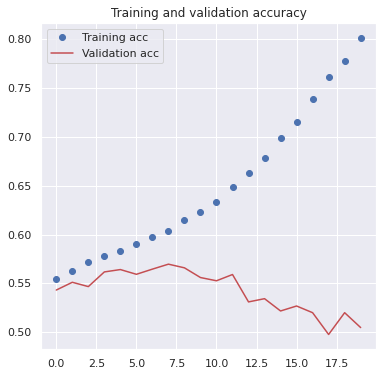

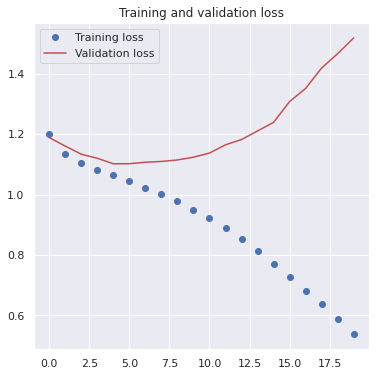

In [ ]:
# Let's plot our results again:
import matplotlib.pyplot as plt
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Predication

In [ ]:
# Get Prediction Results for TEST data from the LSTM model
predY = model.predict(testX)
print(predY)

[[2.2033547e-04 3.7532607e-01 2.7906178e-02 1.0039506e-01 2.0781080e-01
  2.8834152e-01]
 [7.3144911e-04 1.1639606e-01 2.5887582e-02 5.8971889e-02 6.8973964e-01
  1.0827334e-01]
 [1.1186458e-07 9.9604707e-03 5.5982149e-01 3.6406121e-01 1.4803644e-02
  5.1353078e-02]
 ...
 [1.2368912e-06 1.0461614e-01 7.0746318e-02 6.8783462e-01 5.6789503e-02
  8.0012217e-02]
 [9.5853848e-06 1.2127471e-02 3.1893780e-03 9.6229658e-02 5.2414125e-01
  3.6430264e-01]
 [4.9492675e-05 1.5722252e-03 7.3293396e-03 1.4580263e-01 3.2993644e-01
  5.1530987e-01]]


In [ ]:
# Get Prediction Results for TRAINING data from the LSTM model

predY_Train = model.predict(trainX)
print(predY_Train)

[[1.01342124e-07 3.02847311e-05 1.71741904e-05 2.21939059e-03
  4.49828297e-01 5.47904730e-01]
 [1.01436803e-09 1.00266607e-05 1.06899336e-06 1.56997144e-03
  1.16481651e-02 9.86770749e-01]
 [2.74652739e-05 8.28295648e-02 3.69572848e-01 4.96036887e-01
  4.08847220e-02 1.06484685e-02]
 ...
 [2.14083573e-09 4.39614087e-04 3.76244025e-05 2.73888954e-03
  9.28127673e-03 9.87502635e-01]
 [1.58518321e-06 6.44405955e-04 9.71462985e-04 5.46233207e-02
  2.22365428e-02 9.21522677e-01]
 [2.18680930e-06 7.63752079e-03 5.56955300e-02 1.56080008e-01
  4.91659045e-01 2.88925707e-01]]


In [ ]:
predY = np.argmax(predY, axis=1) 
print (predY)

predY_Train = np.argmax(predY_Train, axis=1) 
print (predY_Train)

[1 4 2 ... 3 4 5]
[5 5 3 ... 5 5 4]


### Confusion Matrix

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cnf_matrix= confusion_matrix(testY, predY)
print(cnf_matrix)

cnf_matrix_train= confusion_matrix(trainY, predY_Train)
print(cnf_matrix_train)

[[  18   28   38   26   58]
 [   8   63   90   48   99]
 [  14   80  117  107  228]
 [   2   44  141  236  624]
 [  20   67  149  372 1852]]
[[ 350   87   95   41   80]
 [  14  895  157   61  114]
 [   9  104 1789  154  221]
 [   7   58  199 2698  899]
 [   4   22   99  312 9643]]


Text(30.5, 0.5, 'ACTUAL')

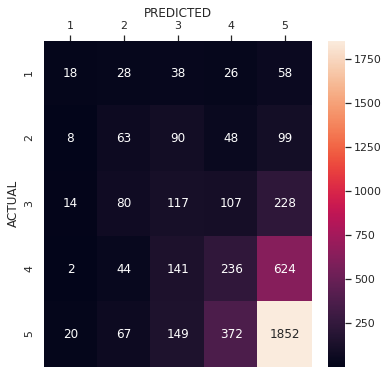

In [ ]:
# PLOT CONFUSION MATRIX For Test Data

xticklabels = np.arange(1,6,1)

fig, ax = plt.subplots(1)
ax.xaxis.set_label_position('top') 

ax.xaxis.tick_top()
sns.heatmap(cnf_matrix, xticklabels=xticklabels, yticklabels=xticklabels, annot=True, fmt='d', ax=ax)

plt.xlabel("PREDICTED")
plt.ylabel("ACTUAL")

Text(30.5, 0.5, 'ACTUAL')

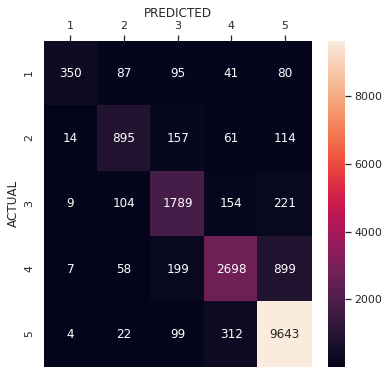

In [ ]:
# PLOT CONFUSION MATRIX For Training Data

xticklabels = np.arange(1,6,1)

fig, ax = plt.subplots(1)
ax.xaxis.set_label_position('top') 

ax.xaxis.tick_top()
sns.heatmap(cnf_matrix_train, xticklabels=xticklabels, yticklabels=xticklabels, annot=True, fmt='d', ax=ax)

plt.xlabel("PREDICTED")
plt.ylabel("ACTUAL")


### Mean Squared Error and Root Mean Square

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

mae = mean_absolute_error(testY, predY)
rms = sqrt(mean_squared_error(testY, predY))

print("Mean Absolute Error for Validation Data is: ", mae)
print("RMS Error for Validation Data is: ", rms)

mae_train = mean_absolute_error(trainY, predY_Train)
rms_train = sqrt(mean_squared_error(trainY, predY_Train))

print("Mean Absolute Error for Training Data is: ", mae_train)
print("RMS Error for Training Data is: ", rms_train)

Mean Absolute Error for Validation Data is:  0.7476264075954957
RMS Error for Validation Data is:  1.2005739409095468
Mean Absolute Error for Training Data is:  0.21532685512367492
RMS Error for Training Data is:  0.6260150767554151


## Model Preformance Improvement 



*   Activation:
*   Loss:
*   optimizer:
*   Metrics:
*   Epochs :
*   batch_size
*   Verbose:













### Model 1 


---


In this model, the number of densse layers chnge to be 8. The Accuracy is




sparse_categorical_accuracy: 51.36%


In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(SENTENCE_LENGTH, EMBEDDED_VECTOR_DIM)))
model.add(Dense(8, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])    
model.summary()

history = model.fit(trainX,
          trainY,
          epochs=20,
          batch_size=32,
          verbose=1,
          validation_data=(testX, testY))

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 808       
Total params: 61,208
Trainable params: 61,208
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
566/566 [==============================] - 3s 4ms/step - loss: 1.2695 - sparse_categorical_accuracy: 0.5430 - val_loss: 1.1824 - val_sparse_categorical_accuracy: 0.5434
Epoch 2/20
566/566 [==============================] - 2s 3ms/step - loss: 1.1531 - sparse_categorical_accuracy: 0.5536 - val_loss: 1.1510 - val_sparse_categorical_accuracy: 0.5507
Epoch 3/20
566/566 [==============================] - 2s 3ms/step - loss: 1.1177 - sparse_categorical_accuracy: 0.5662 - val_loss: 1.1233 - val_sparse_

In [ ]:
scores = model.evaluate(testX, testY)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

142/142 [==============================] - 0s 2ms/step - loss: 1.4259 - sparse_categorical_accuracy: 0.5136

sparse_categorical_accuracy: 51.36%


### Model 2

Adding extra layer

In [ ]:

# # Building and training the model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(100, input_shape=(SENTENCE_LENGTH, EMBEDDED_VECTOR_DIM)))
model.add(Dense(6))
model.add(Dense(6, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
model.summary()


history4 = model.fit(trainX,
          trainY,
          epochs=20,
          batch_size=32,
          verbose=1,
          validation_data=(testX, testY))

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_73 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dense_60 (Dense)             (None, 6)                 606       
_________________________________________________________________
dense_61 (Dense)             (None, 6)                 42        
Total params: 61,048
Trainable params: 61,048
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
566/566 [==============================] - 6s 8ms/step - loss: 1.3150 - accuracy: 0.5459 - val_loss: 2.0077 - val_accuracy: 0.2570
Epoch 2/20
566/566 [==============================] - 4s 6ms/step - loss: 1.2096 - accuracy: 0.5677 - val_loss: 1.5237 - val_accuracy: 0.4105
Epoch 3/20
566/566 [==============================] - 4s 7ms/step - loss: 1.2226 - accuracy: 0.

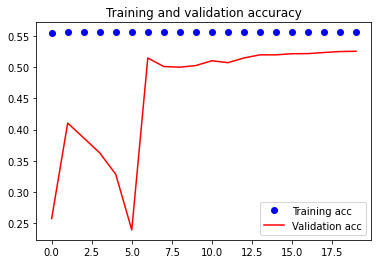

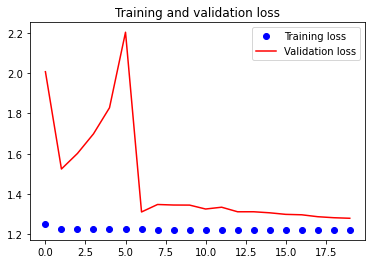

In [ ]:
# Let's plot our results again:
import matplotlib.pyplot as plt
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Model 3 


---

In this model, The chnages made are:

1.   Danse 8
2.   epochs 30


sparse_categorical_accuracy: 52.68%

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(SENTENCE_LENGTH, EMBEDDED_VECTOR_DIM)))
model.add(Dense(8, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])    
model.summary()

history = model.fit(trainX,
          trainY,
          epochs=30,
          batch_size=32,
          verbose=1,
          validation_data=(testX, testY))

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 808       
Total params: 61,208
Trainable params: 61,208
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
566/566 [==============================] - 3s 4ms/step - loss: 1.2867 - sparse_categorical_accuracy: 0.5396 - val_loss: 1.1856 - val_sparse_categorical_accuracy: 0.5440
Epoch 2/20
566/566 [==============================] - 2s 3ms/step - loss: 1.1521 - sparse_categorical_accuracy: 0.5585 - val_loss: 1.1499 - val_sparse_categorical_accuracy: 0.5482
Epoch 3/20
566/566 [==============================] - 2s 3ms/step - loss: 1.1270 - sparse_categorical_accuracy: 0.5614 - val_loss: 1.1269 - val_sparse_

In [ ]:
scores = model.evaluate(testX, testY)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

142/142 [==============================] - 0s 2ms/step - loss: 1.4938 - sparse_categorical_accuracy: 0.5268

sparse_categorical_accuracy: 52.68%


### Model 4


---

In this model, The chnages made is in epoches only:

1.   Danse 8
2.   epochs 10

sparse_categorical_accuracy: 54.82%
We can see that reduce the epochs improve the accuracy of the model


In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(SENTENCE_LENGTH, EMBEDDED_VECTOR_DIM)))
model.add(Dense(8, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])    
model.summary()

history = model.fit(trainX,
          trainY,
          epochs=10,
          batch_size=32,
          verbose=1,
          validation_data=(testX, testY))

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_58 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dense_70 (Dense)             (None, 8)                 808       
Total params: 61,208
Trainable params: 61,208
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
566/566 [==============================] - 3s 4ms/step - loss: 1.2834 - sparse_categorical_accuracy: 0.5420 - val_loss: 1.1810 - val_sparse_categorical_accuracy: 0.5427
Epoch 2/10
566/566 [==============================] - 2s 3ms/step - loss: 1.1485 - sparse_categorical_accuracy: 0.5594 - val_loss: 1.1504 - val_sparse_categorical_accuracy: 0.5502
Epoch 3/10
566/566 [==============================] - 2s 3ms/step - loss: 1.1092 - sparse_categorical_accuracy: 0.5715 - val_loss: 1.1515 - val_sparse_

In [ ]:
scores = model.evaluate(testX, testY)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

142/142 [==============================] - 0s 2ms/step - loss: 1.1115 - sparse_categorical_accuracy: 0.5482

sparse_categorical_accuracy: 54.82%


### Model 5


---
In this model, The chnages made are:

1.   Danse 8
2.   epochs 30
3.   verbose 2
4.   LSTM 200

sparse_categorical_accuracy: 55.20%


In [ ]:
model = Sequential()
model.add(LSTM(200, input_shape=(SENTENCE_LENGTH, EMBEDDED_VECTOR_DIM)))
model.add(Dense(8, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])    
model.summary()

history = model.fit(trainX,
          trainY,
          epochs=10,
          batch_size=32,
          verbose=2,
          validation_data=(testX, testY))

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 200)               200800    
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 1608      
Total params: 202,408
Trainable params: 202,408
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
566/566 - 3s - loss: 1.2129 - sparse_categorical_accuracy: 0.5550 - val_loss: 1.1937 - val_sparse_categorical_accuracy: 0.5432
Epoch 2/10
566/566 - 1s - loss: 1.1461 - sparse_categorical_accuracy: 0.5608 - val_loss: 1.1592 - val_sparse_categorical_accuracy: 0.5500
Epoch 3/10
566/566 - 1s - loss: 1.1119 - sparse_categorical_accuracy: 0.5707 - val_loss: 1.1443 - val_sparse_categorical_accuracy: 0.5500
Epoch 4/10
566/566 - 1s - loss: 1.0852 - sparse_categorical_accuracy: 0.5792 - val_loss: 1.1117

In [ ]:
scores = model.evaluate(testX, testY)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

142/142 [==============================] - 0s 2ms/step - loss: 1.1554 - sparse_categorical_accuracy: 0.5520

sparse_categorical_accuracy: 55.20%


#Conclusion

We have tried so many models however it did not affect the accuracy much among the best we have choosen the model 5 has the highes among all tryings.
Model 5 we have increased number of neurons with the accuracy of 55.20%.